Hi there! This is my first kernel dealing with textual data so any constructive feedabacks are higly appreciated.

This dataset contains data of over 7 topics namely biology, robotics, cryptography, diy, travel, cooking, robotics and physics extracted from Stack Exchange. Each of these topics except physics have been classified as to which topic data belongs. So our task is to do predictions on unseen physics questions.

Since our data won't be related to each other for example tags in travel won't be related to tags in cryptography hence I will be using unsupervised learning on physics dataset which is the test dataset. 

In [1]:
#Importing all the neccesary libraries
import numpy as np 
import pandas as pd 

import os
print(os.listdir("input"))

import regex as re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# viz
import matplotlib.pyplot as plt
%matplotlib inline
import sys

# feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer 

# for clustering
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete, average, weighted
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.metrics import silhouette_score

['.ipynb_checkpoints', '951967.zip', 'Bug report 10.csv', 'Bug report 100.csv', 'Bug report.csv', 'JIRA-ALL.csv', 'JIRA-BUG.csv', 'JIRA.csv', 'preprocessed_data.csv']


Making dictionary to put all the data in the same hood.

In [2]:
data=pd.read_csv('Input/JIRA-BUG.csv')
data = data.reset_index()
data.head()

,index,Summary,Bug Location,Issue key,Issue id,Issue Type,Status,Project key,Project name,Project type,...,Comment.64,Comment.65,Comment.66,Comment.67,Comment.68,Comment.69,Comment.70,Parent,Parent summary,Status Category
0,0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,Admin Portal,CORE-4396,57063,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
1,1,[Dev][Admin Portal][Create New][Create From ex...,Admin Portal,CORE-4385,57039,Bug,In Progress,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
2,2,Duplicate items while using Search items by ke...,Automation Test,CORE-4377,57007,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do
3,3,[AP] Default language and default region of st...,Admin Portal,CORE-4366,56971,Bug,QA,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress
4,4,[Unity][SDK] Single draft store makes subscrip...,SDK,CORE-4365,56960,Bug,To Do,CORE,Justice - Core Team,software,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,To Do


In [3]:
cols_of_interest=["Summary", "Status","Description","Priority","Resolution", "Issue Type", "Bug Location"]
data=data[cols_of_interest]
print(data.shape)
data.head()

(651, 7)


,Summary,Status,Description,Priority,Resolution,Issue Type,Bug Location
0,[Dev][Demo][Admin Portal][Edit Bundle items]: ...,To Do,This issue occurs on *Add new bundle items.*\n...,P1,NaN,Bug,Admin Portal
1,[Dev][Admin Portal][Create New][Create From ex...,In Progress,This issue occurs on Create new Role and Creat...,P1,NaN,Bug,Admin Portal
2,Duplicate items while using Search items by ke...,To Do,"While making script for cleanup, we found that...",P2,NaN,Bug,Automation Test
3,[AP] Default language and default region of st...,QA,When we open Stores menu and look at the store...,P1,NaN,Bug,Admin Portal
4,[Unity][SDK] Single draft store makes subscrip...,To Do,The restriction of single draft store makes su...,P1,NaN,Bug,SDK


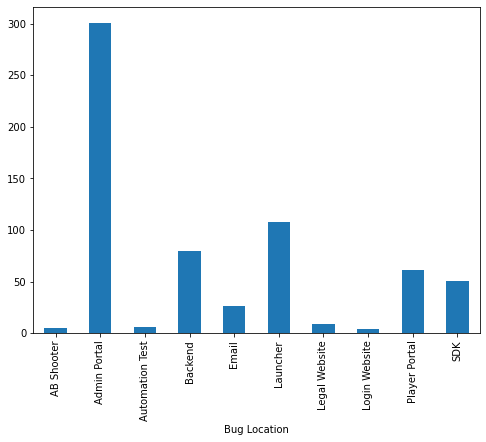

In [4]:
fig = plt.figure(figsize=(8,6))
data.groupby('Bug Location').Status.count().plot.bar(ylim=0)
plt.show()

In [5]:
data.Description = data.Description.fillna("0")
data.isnull().sum()

Summary          0
Status           0
Description      0
Priority         0
Resolution      97
Issue Type       0
Bug Location     0
dtype: int64

**Text data preprocessing steps**

1- Data Cleaning(either using regex or BeautifulSoup): 
a) Removing HTML characters. 
b) Removing punctuation. 
c) Decoding encoded data.
d) Split attached words.
e) Removing URLs. 
f) Apostrophe removal.
g) Removing Expressions. 
h) Uppercase & Lowercase letters 
i) Numbers such as amounts and data.

2- Data Tokenization(using word_tokenize in nltk.tokenize) 
Segregation of text into individual words i.e tokens.

3- Stopword Removal(using stopwords in nltk.corpus)
Discarding too common words or words which are not going to be helpful in our analysis.

4- Stemming(using WordNetLemmatizer in nltk.stem) 
Combining different variants of words into a single parent word that conveys same meaning.

5-Vectorization (either using TfidVectorizer or Countvectorizer in sklearn.feature_extraction.text or word embeddings) Changing text data into vector format.


In [6]:
stops = set(stopwords.words("english"))

In [7]:
data.dtypes

Summary         object
Status          object
Description     object
Priority        object
Resolution      object
Issue Type      object
Bug Location    object
dtype: object

In [8]:
dataConcat = pd.DataFrame()
dataConcat = data.Summary +" "+data.Status +" "+ data.Description+" "+data["Bug Location"]
dataConcat.to_csv("./Output/data_concat.csv")

In [9]:
def clean_Description(content):
#     content = table.Description
    #Converting text to lowercase characters
    content = content.apply(lambda x: x.lower())
    #Removing HTML tags
    content = content.apply(lambda x: re.sub(r'\<[^<>]*\>','',x))
    #Removing any character which does not match to letter,digit or underscore
    content = content.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    #Removing space,newline,tab
    content = content.apply(lambda x: re.sub(r'\s',' ',x))
    #Removing punctuation
    content = content.apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
    #Removing numeric
    content = content.apply(lambda x: re.sub(r'[0-9]','',x))
    #Tokenizing data
    content = content.apply(lambda x: word_tokenize(x))
    #Removing stopwords
    content = content.apply(lambda x: [i for i in x if i not in stops])
    type(content)
    return(content)

In [10]:
# data['bug']
dataClean = pd.DataFrame()
dataClean = clean_Description(dataConcat)
dataClean.head()

0    [dev, demo, portal, edit, bundle, items, add, ...
1    [dev, portal, create, new, create, existing, a...
2    [duplicate, items, using, search, items, keywo...
3    [ap, default, language, default, region, store...
4    [unity, sdk, single, draft, store, makes, subs...
dtype: object

In [11]:
# desc = ' '
# for x in data.Description:
#     for y in x:
#         desc+=' '+y

In [12]:
# plt.figure(figsize=(8,10))
# wc = WordCloud(max_words=1000,random_state=1).generate(desc)
# plt.imshow(wc)
# plt.show()

In [13]:
dataClean.dtypes

dtype('O')

In [14]:
wordnet = WordNetLemmatizer()
dataClean = dataClean.apply(lambda x:[wordnet.lemmatize(i,pos='v') for i in x])
dataClean.head()

0    [dev, demo, portal, edit, bundle, items, add, ...
1    [dev, portal, create, new, create, exist, able...
2    [duplicate, items, use, search, items, keyword...
3    [ap, default, language, default, region, store...
4    [unity, sdk, single, draft, store, make, subsc...
dtype: object

## Hierarchical clustering

We experiment with multiple hierarchical clustering criteria:
* Ward (maximize the decrease in intra-cluster variance with respect to all clusters)
* Single (move point to cluster of nearest neighbor)
* Complete (move point to the cluster with minimum distance to farthest point)

Ward clustering yielded reasonable results, as did complete clustering. Many cases Using the single criterion results in a degenerate case.


In [15]:
# data.Description = ','.join(str(v) for v in data.Description)
# data.head()
# data.fillna('0')
dataClean.dtypes

dtype('O')

In [16]:
Summary = dataClean.astype(str)
# Summary = str(data.summary)
# data.Summary.astype(str)
Summary.dtypes

dtype('O')

In [17]:
tfidf_vectorizer = TfidfVectorizer(lowercase=False)

In [18]:
tfidf_matrix = tfidf_vectorizer.fit_transform(Summary)
tfidf_matrix
# np.savetxt("./Output/tfidf_matrix.csv", tfidf_matrix, delimiter=",")

<651x2107 sparse matrix of type '<class 'numpy.float64'>'
	with 16655 stored elements in Compressed Sparse Row format>

In [19]:
dist = cosine_similarity(tfidf_matrix)
print(dist)
# dist = jaccard_score(tfidf_matrix)
np.savetxt("./Output/dist.csv", dist, delimiter=",")

[[1.         0.13818391 0.10894825 ... 0.02286726 0.03048713 0.04435376]
 [0.13818391 1.         0.07051476 ... 0.02456428 0.02670638 0.02340856]
 [0.10894825 0.07051476 1.         ... 0.0063286  0.03359654 0.1216481 ]
 ...
 [0.02286726 0.02456428 0.0063286  ... 1.         0.0676079  0.05075922]
 [0.03048713 0.02670638 0.03359654 ... 0.0676079  1.         0.04921502]
 [0.04435376 0.02340856 0.1216481  ... 0.05075922 0.04921502 1.        ]]


## Agglomerative Hierarchical Clustering

### Average

In [20]:
dist = dist - dist.min() # get rid of some pesky floating point errors that give neg. distance
linkage_matrix = average(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

## Visualization

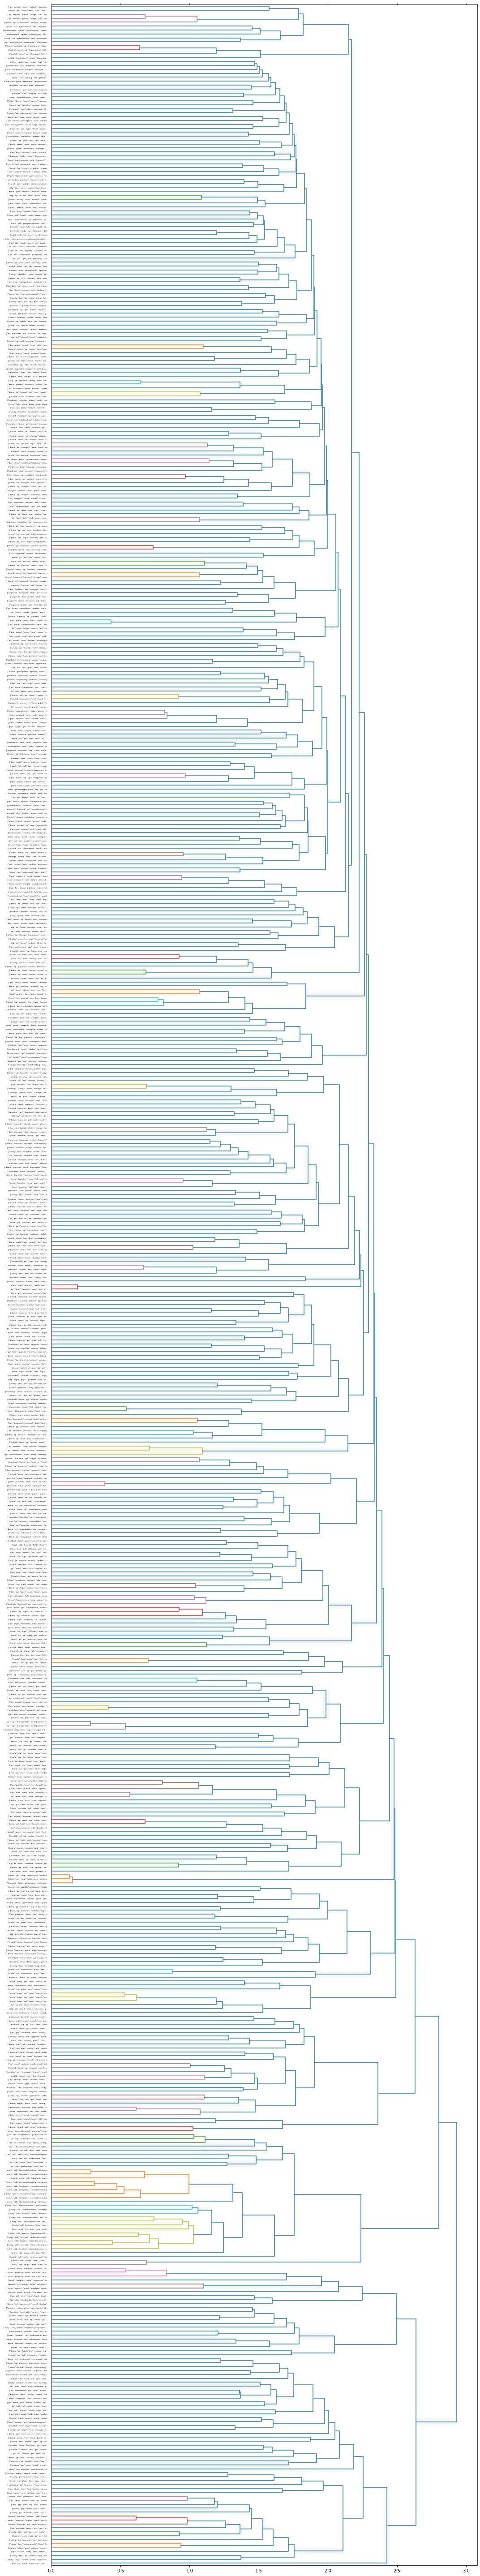

In [21]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

 Visualizing our cleaned bug data using WordCloud

# Analysis

We now take the raw clusters achieved and use the silhouette score and elbow method to evaluate.

In [22]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores
    

Silhouette score with 2 clusters: -0.15974141326611974
Silhouette score with 3 clusters: -0.7904773322490003
Silhouette score with 4 clusters: -0.8058581498710797
Silhouette score with 5 clusters: -0.8262717273310178
Silhouette score with 6 clusters: -0.8414322099696285
Silhouette score with 7 clusters: -0.8499709692071625
Silhouette score with 8 clusters: -0.858100224700568
Silhouette score with 9 clusters: -0.9097188353177598
Silhouette score with 10 clusters: -0.9149326199826948
Silhouette score with 11 clusters: -0.9256419228010286
Silhouette score with 12 clusters: -0.9284084441411748
Silhouette score with 13 clusters: -0.9296099790247531
Silhouette score with 14 clusters: -0.9368507299255489
Silhouette score with 15 clusters: -0.94017002445514
Silhouette score with 16 clusters: -0.9440580669021597
Silhouette score with 17 clusters: -0.9461777392702074
Silhouette score with 18 clusters: -0.947261313137831
Silhouette score with 19 clusters: -0.9526017782515647
Silhouette score with

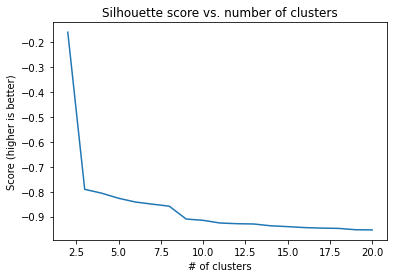

In [23]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)

### Complete

In [24]:
dist = dist - dist.min() # get rid of some pesky floating point errors that give neg. distance
linkage_matrix = complete(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

C:\Users\GF\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:356: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


## Visualization

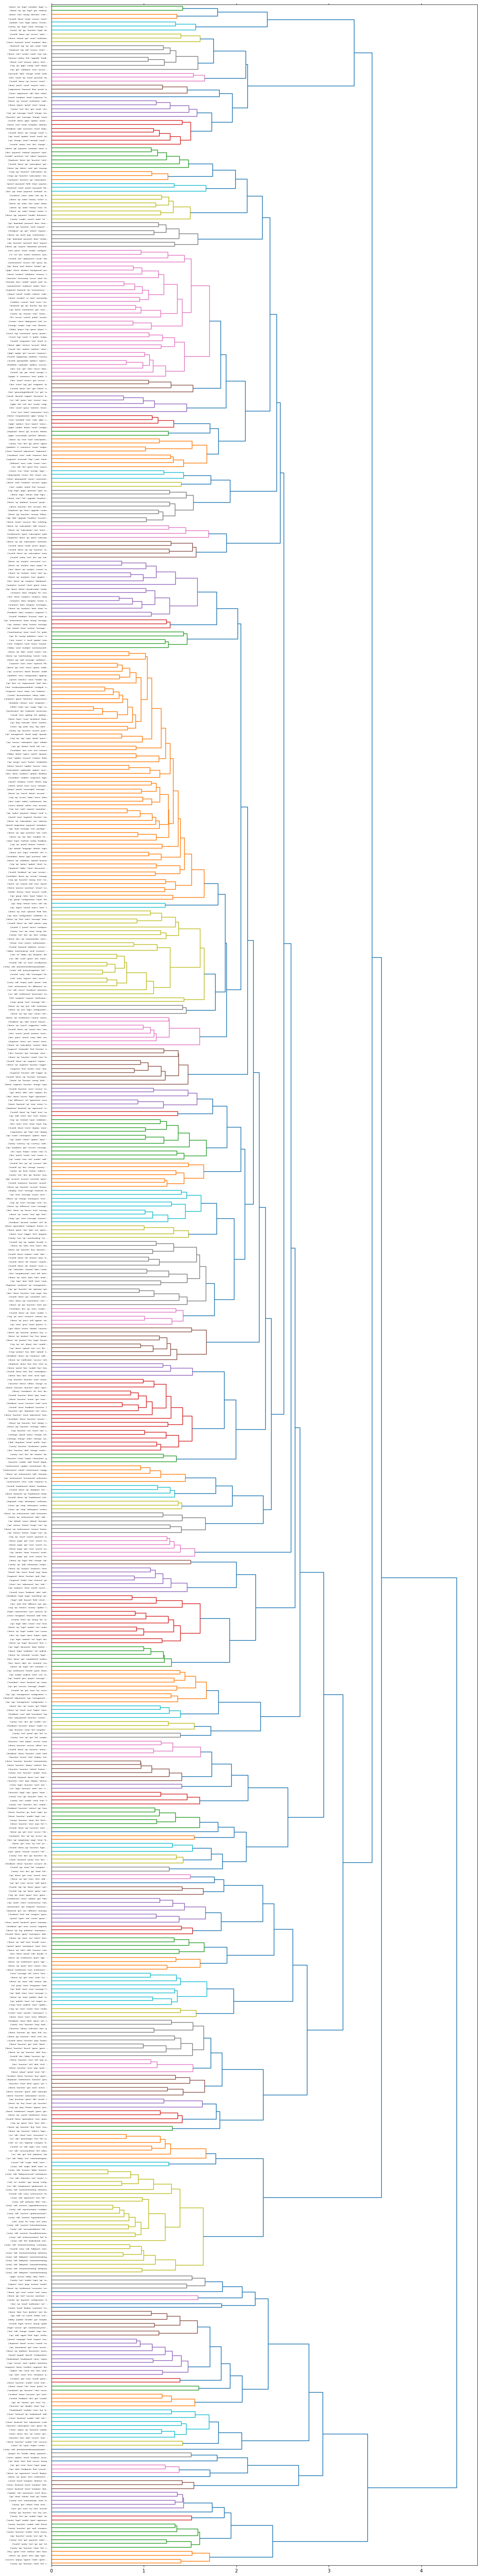

In [25]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

# Analysis

In [26]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.15533445171020666
Silhouette score with 3 clusters: -0.776745074944715
Silhouette score with 4 clusters: -0.8006645522382754
Silhouette score with 5 clusters: -0.814101749517422
Silhouette score with 6 clusters: -0.8270219586135444
Silhouette score with 7 clusters: -0.8373081913879543
Silhouette score with 8 clusters: -0.8436675404673227
Silhouette score with 9 clusters: -0.8472525870783028
Silhouette score with 10 clusters: -0.8529826064472305
Silhouette score with 11 clusters: -0.8591052019320213
Silhouette score with 12 clusters: -0.8664116625089449
Silhouette score with 13 clusters: -0.9046905581315732
Silhouette score with 14 clusters: -0.909993870239677
Silhouette score with 15 clusters: -0.9122711949768757
Silhouette score with 16 clusters: -0.9167414631793073
Silhouette score with 17 clusters: -0.9182724638787142
Silhouette score with 18 clusters: -0.9299364313028546
Silhouette score with 19 clusters: -0.9321522016927807
Silhouette score wit

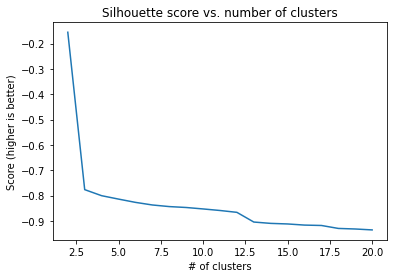

In [27]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)

### Ward

In [28]:
dist = dist - dist.min() # get rid of some pesky floating point errors that give neg. distance
linkage_matrix = ward(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

C:\Users\GF\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## Visualization

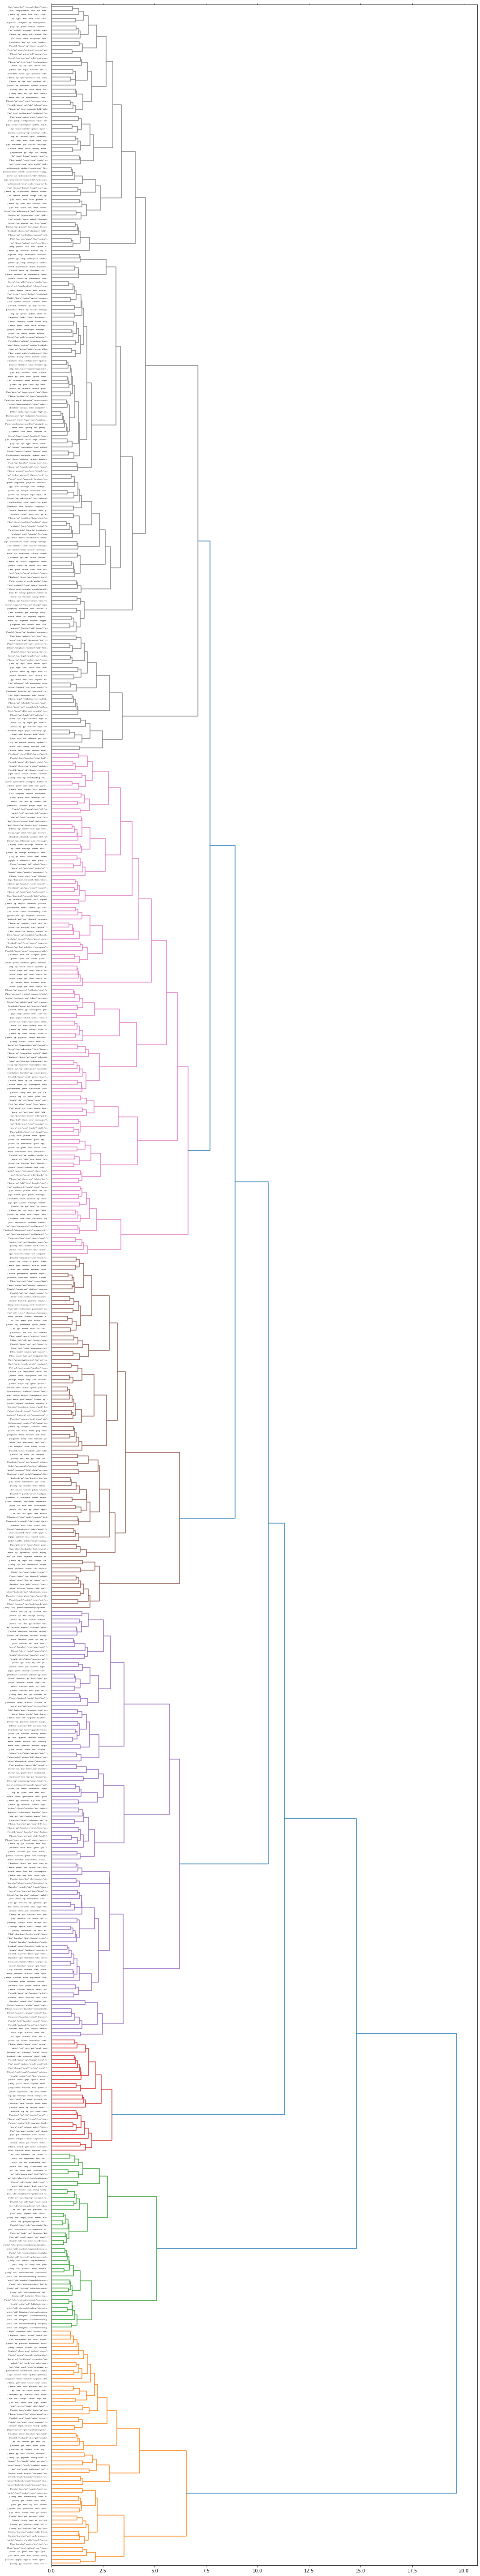

In [29]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

# Analysis

In [30]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.14319149628462152
Silhouette score with 3 clusters: -0.7683904132676797
Silhouette score with 4 clusters: -0.7951405490839978
Silhouette score with 5 clusters: -0.8176308877101872
Silhouette score with 6 clusters: -0.8427708023609773
Silhouette score with 7 clusters: -0.8627252535252075
Silhouette score with 8 clusters: -0.8721674663069672
Silhouette score with 9 clusters: -0.8794858981188826
Silhouette score with 10 clusters: -0.8829263425300241
Silhouette score with 11 clusters: -0.8873036424659235
Silhouette score with 12 clusters: -0.8895224967131987
Silhouette score with 13 clusters: -0.8942547595481019
Silhouette score with 14 clusters: -0.8957830085275192
Silhouette score with 15 clusters: -0.9016622839708961
Silhouette score with 16 clusters: -0.9604180501692364
Silhouette score with 17 clusters: -0.9623431233333534
Silhouette score with 18 clusters: -0.964352767838701
Silhouette score with 19 clusters: -0.9656412161364495
Silhouette score w

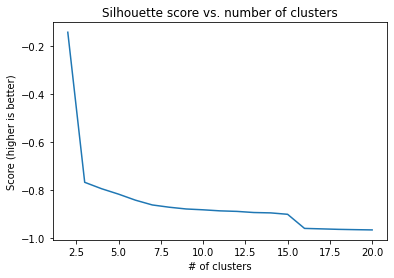

In [31]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)

### Weighted

In [32]:
dist = dist - dist.min() # get rid of some pesky floating point errors that give neg. distance
linkage_matrix = ward(dist) # replace with complete, single, or other scipy.cluster.hierarchical algorithms

C:\Users\GF\anaconda3\lib\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


## Visualization

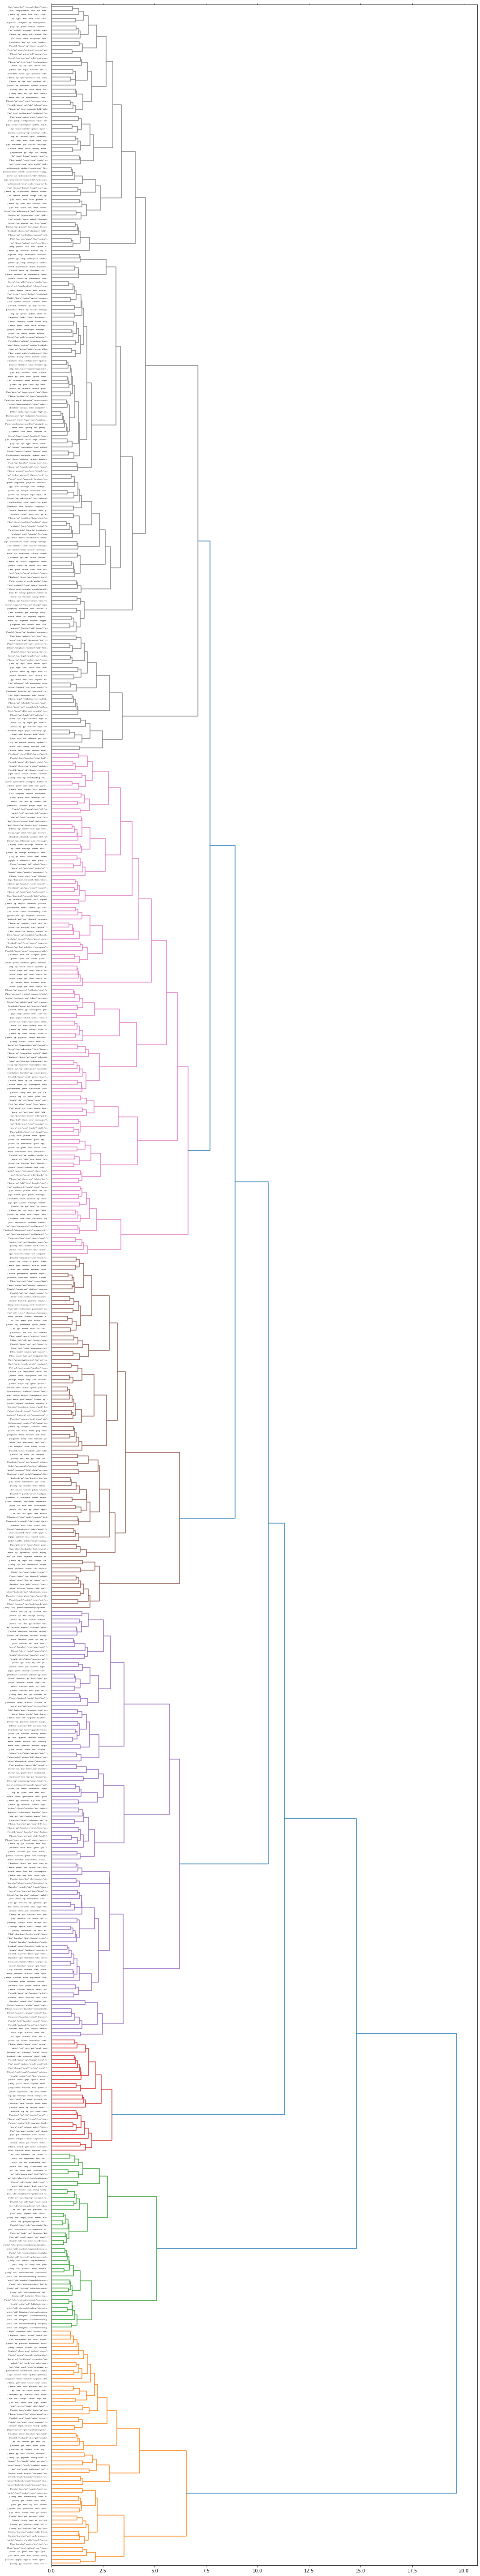

In [33]:
sys.setrecursionlimit(10000)
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39 # max distance between points to be considered together. can be tuned.
MAX_TITLE_LEN = 50

fig, ax = plt.subplots(figsize=(15, 80)) # set size
ax = dendrogram(linkage_matrix, orientation="right", color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4,
                labels=Summary.apply(lambda x: x if len(x) < MAX_TITLE_LEN else x[:MAX_TITLE_LEN  - 3] + "...").tolist())

plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.savefig('ward_clusters_all.png', dpi=300)

# Analysis

In [34]:
def silhouette_k(distance_matrix, linkage_matrix, max_k=20):
    scores = []
    for i in range(2, max_k+1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(distance_matrix, clusters, metric='precomputed')
        print("Silhouette score with {} clusters:".format(i), score)
        scores.append(score)
    plt.title("Silhouette score vs. number of clusters")
    plt.xlabel("# of clusters")
    plt.ylabel("Score (higher is better)")
    plt.plot(np.arange(2, max_k+1), scores)
    plt.show()
    return scores

Silhouette score with 2 clusters: -0.14319149628462152
Silhouette score with 3 clusters: -0.7683904132676797
Silhouette score with 4 clusters: -0.7951405490839978
Silhouette score with 5 clusters: -0.8176308877101872
Silhouette score with 6 clusters: -0.8427708023609773
Silhouette score with 7 clusters: -0.8627252535252075
Silhouette score with 8 clusters: -0.8721674663069672
Silhouette score with 9 clusters: -0.8794858981188826
Silhouette score with 10 clusters: -0.8829263425300241
Silhouette score with 11 clusters: -0.8873036424659235
Silhouette score with 12 clusters: -0.8895224967131987
Silhouette score with 13 clusters: -0.8942547595481019
Silhouette score with 14 clusters: -0.8957830085275192
Silhouette score with 15 clusters: -0.9016622839708961
Silhouette score with 16 clusters: -0.9604180501692364
Silhouette score with 17 clusters: -0.9623431233333534
Silhouette score with 18 clusters: -0.964352767838701
Silhouette score with 19 clusters: -0.9656412161364495
Silhouette score w

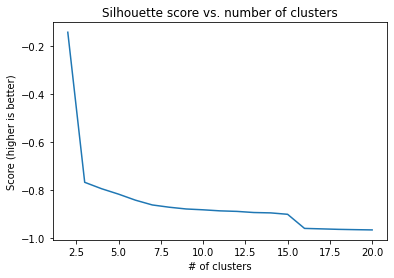

In [35]:
np.fill_diagonal(dist, 0)
_ = silhouette_k(dist, linkage_matrix)